In [32]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils import resample
import numpy as np

# Load the dataset
df = pd.read_csv('merged_dataset1.csv')

# Filter out payment_type == 0
df_filtered = df.query("payment_type != 0")

# Recode payment_type values: 2, 3, 4 to 0 (cash/others); keep 1 as is (credit card)
df_filtered['payment_type'] = df_filtered['payment_type'].replace([2, 3, 4], 0)

# Split the dataset into the majority and minority classes
df_majority = df_filtered[df_filtered.payment_type == 1]
df_minority = df_filtered[df_filtered.payment_type == 0]

# Upsample the minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     
                                 n_samples=len(df_majority),    
                                 random_state=123)

# Combine the majority class with the upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

features_columns = ['passenger_count', 'trip_distance', 'RatecodeID', 'total_amount', 'trip_duration', 'pickup_borough', 'dropoff_borough']
df_upsampled = df_upsampled[features_columns + ['payment_type']]

print(df_upsampled.payment_type.value_counts())

# Prepare features and target variable
features_upsampled = df_upsampled[['passenger_count', 'trip_distance', 'RatecodeID', 'total_amount', 'trip_duration']]
# Adding the one-hot encoded borough features
features_upsampled = pd.concat([features_upsampled, pd.get_dummies(df_upsampled[['pickup_borough', 'dropoff_borough']], drop_first=True)], axis=1)
target_upsampled = df_upsampled['payment_type']
complete_dataset_upsampled = pd.concat([features_upsampled, target_upsampled], axis=1)
complete_dataset_upsampled.to_csv('complete_upsampled_dataset.csv', index=False)

# Splitting the upsampled dataset into training and testing sets
X_train_upsampled, X_test_upsampled, y_train_upsampled, y_test_upsampled = train_test_split(features_upsampled, target_upsampled, test_size=0.3, random_state=42)

# Ensure all values are non-negative for MultinomialNB
X_train_upsampled = np.abs(X_train_upsampled)
X_test_upsampled = np.abs(X_test_upsampled)

# Training a Multinomial Naive Bayes model on the upsampled dataset
model_upsampled = MultinomialNB()
model_upsampled.fit(X_train_upsampled, y_train_upsampled)

# Predicting on the test set
y_pred_upsampled = model_upsampled.predict(X_test_upsampled)

# Evaluating the model
accuracy_upsampled = accuracy_score(y_test_upsampled, y_pred_upsampled)
report_upsampled = classification_report(y_test_upsampled, y_pred_upsampled)

print(f'Accuracy: {accuracy_upsampled}')
print(f'Classification Report:\n{report_upsampled}')


payment_type
1    7640
0    7640
Name: count, dtype: int64
Accuracy: 0.7120418848167539
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.85      0.75      2306
           1       0.79      0.58      0.67      2278

    accuracy                           0.71      4584
   macro avg       0.73      0.71      0.71      4584
weighted avg       0.73      0.71      0.71      4584



C:\Users\varun\AppData\Local\Temp\ipykernel_27800\3715437692.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['payment_type'] = df_filtered['payment_type'].replace([2, 3, 4], 0)


In [33]:
print(complete_dataset_upsampled.sample(5))


      passenger_count  trip_distance  RatecodeID  total_amount  trip_duration  \
2481                1           1.22         1.0         11.76       6.816667   
3995                1           3.15         1.0         19.30      22.983333   
8470                1           4.20         1.0         23.76      19.400000   
1839                1          13.80         1.0         51.94      28.400000   
6947                3           0.37         1.0         11.76       7.050000   

      pickup_borough_Brooklyn  pickup_borough_EWR  pickup_borough_Manhattan  \
2481                    False               False                      True   
3995                    False               False                      True   
8470                    False               False                      True   
1839                    False               False                     False   
6947                    False               False                      True   

      pickup_borough_Queens  pickup_bo

In [26]:
# Print samples from the training set
print("Training set sample:")
print(X_train_upsampled.join(y_train_upsampled).sample(5))




Training set sample:
      passenger_count  trip_distance  RatecodeID  total_amount  trip_duration  \
7395                1           2.43         1.0         25.64      30.383333   
2756                1           1.27         1.0         13.80      14.083333   
5106                1           3.68         1.0         18.30      20.266667   
1811                2           1.80         1.0         15.36      10.450000   
3974                1           3.28         1.0         14.80       6.866667   

      pickup_borough_Brooklyn  pickup_borough_EWR  pickup_borough_Manhattan  \
7395                    False               False                      True   
2756                    False               False                      True   
5106                    False               False                      True   
1811                    False               False                      True   
3974                    False               False                      True   

      pickup_boro

In [25]:
# Print samples from the testing set
print("\nTesting set sample:")
print(X_test_upsampled.join(y_test_upsampled).sample(5))


Testing set sample:
      passenger_count  trip_distance  RatecodeID  total_amount  trip_duration  \
6860                2           2.50         1.0          15.3      14.200000   
5872                1           2.30         1.0          16.3      15.583333   
8982                1           3.43         1.0          17.8      19.783333   
2415                1           1.10         1.0           9.8       8.216667   
1181                2          16.07         1.0          51.3      48.450000   

      pickup_borough_Brooklyn  pickup_borough_EWR  pickup_borough_Manhattan  \
6860                    False               False                      True   
5872                    False               False                      True   
8982                    False               False                      True   
2415                    False               False                      True   
1181                    False               False                      True   

      pickup_boro

Confusion Matrix:
 [[1951  355]
 [ 965 1313]]
AUC Score: 0.748648408891718


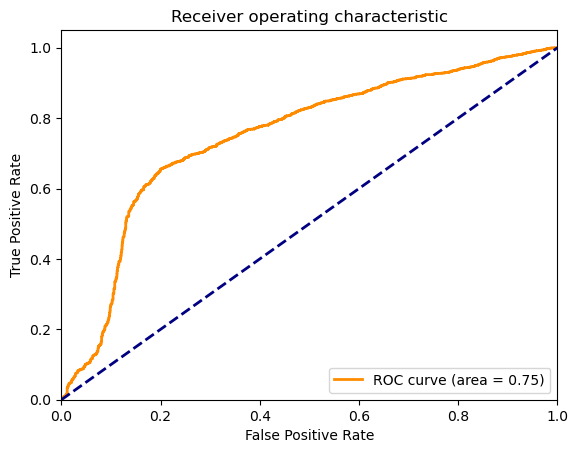

In [27]:
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Calculating the confusion matrix
conf_matrix_upsampled = confusion_matrix(y_test_upsampled, y_pred_upsampled)
print('Confusion Matrix:\n', conf_matrix_upsampled)

# Calculate AUC score
# Note: Need to predict probabilities to calculate AUC
y_pred_proba_upsampled = model_upsampled.predict_proba(X_test_upsampled)[:, 1]
roc_auc_upsampled = roc_auc_score(y_test_upsampled, y_pred_proba_upsampled)
print(f'AUC Score: {roc_auc_upsampled}')

# Plotting the ROC curve
fpr_upsampled, tpr_upsampled, _ = roc_curve(y_test_upsampled, y_pred_proba_upsampled)
plt.figure()
plt.plot(fpr_upsampled, tpr_upsampled, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_upsampled)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()


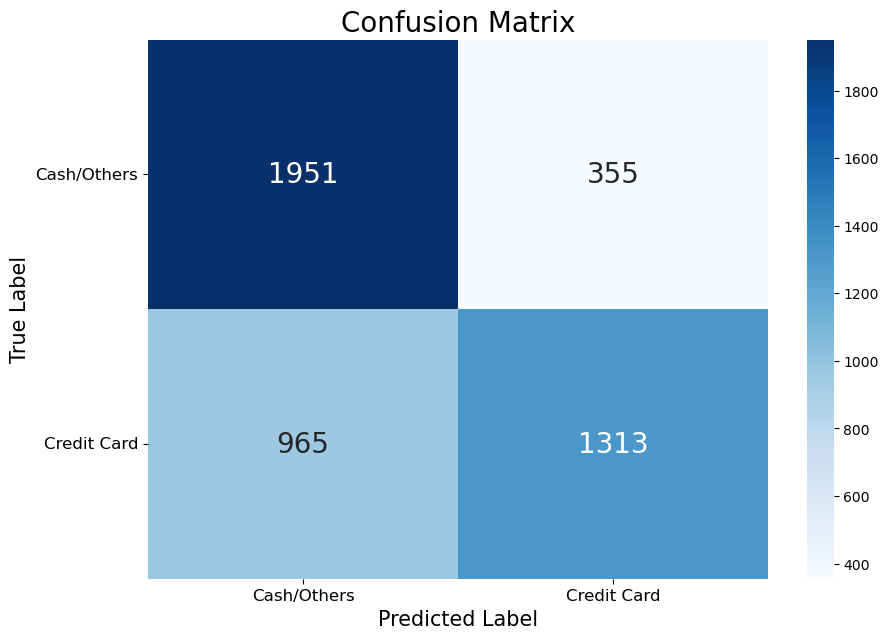

In [28]:
import seaborn as sns

# Calculate the confusion matrix again for clarity
conf_matrix_upsampled = confusion_matrix(y_test_upsampled, y_pred_upsampled)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_upsampled, annot=True, fmt="d", cmap="Blues", annot_kws={"size": 20})
plt.title('Confusion Matrix', fontsize=20)
plt.xlabel('Predicted Label', fontsize=15)
plt.ylabel('True Label', fontsize=15)
plt.xticks([0.5, 1.5], ['Cash/Others', 'Credit Card'], fontsize=12)
plt.yticks([0.5, 1.5], ['Cash/Others', 'Credit Card'], fontsize=12, rotation=0)
plt.show()
